In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import Init_dld as init
import numpy as np
torch.__version__

'1.12.0'

In [3]:
Batch_Size = 256

In [4]:
tr_img, tr_lab, val_img, val_lab = init.Load_data(init.data_dir, is_training=True)
tst_img, tst_lab = init.Load_data(init.data_dir, is_training=False)

--------------------------------------------------
Training sets has 50793 images, validation sets has 17420 images
--------------------------------------------------
--------------------------------------------------
Test sets has 17390 images
--------------------------------------------------


In [5]:
tr_img=torch.from_numpy(tr_img)
tr_lab=torch.from_numpy(tr_lab)
tst_img=torch.from_numpy(tst_img)
tst_lab=torch.from_numpy(tst_lab)

In [6]:
print(tr_img.shape)

torch.Size([50793, 32, 32, 1])


In [7]:
prob,tr_lab=tr_lab.data.max(dim=1)
prob,tst_lab=tst_lab.data.max(dim=1)

In [8]:
print(tr_lab.shape)

torch.Size([50793])


In [9]:
tr_img=tr_img.permute(0, 3, 1, 2)
tst_img=tst_img.permute(0, 3, 1, 2)

In [10]:
classes = {0: 'CON',1: 'MUL_GGO',2: 'HCM',3: 'RET_GGO',4: 'EMP',5: 'NOD',6: 'NOR'}

In [11]:
trainset=torch.utils.data.TensorDataset(tr_img,tr_lab)
testset=torch.utils.data.TensorDataset(tst_img,tst_lab)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)

In [12]:
tr_img.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

torch.Size([50793, 1, 32, 32])

In [13]:
#查看数据类型
print(type(tr_img.data))
print(type(tr_img))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


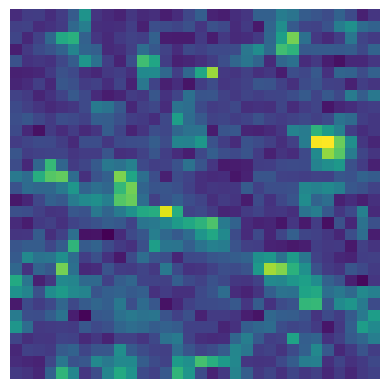

In [14]:
import pickle
import matplotlib.pyplot as plt
with open("data/DLD_pickle_data/training_image.pkl", "rb") as f:
    test_images = pickle.load(f)
image_to_show = test_images[2012]
plt.imshow(image_to_show)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

In [17]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，如ResNet-18/34等，用基本的Block
    基础模块没有压缩,所以expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x,switch=[]):
        halflen=int(len(switch)/2)
        out = self.conv1(x)
        for i in range(0,halflen):
            if(switch[i]==0):
                out[:,i,:,:]=float(0)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        for i in range(halflen,len(switch)):
            if(switch[i]==0):
                out[:,i-halflen,:,:]=0
        out = self.bn2(out)
        
        shortcut = self.shortcut(x)
        
        out += shortcut
        out = torch.relu(out)
        
        return out


In [20]:
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    针对ResNet50/101/152的网络结构,主要是因为第三层是第二层的4倍的关系所以expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        
        self.conv1 = nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(zip_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(zip_channels)
        
        self.conv3 = nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x,switch=[]):
        halflen=int(len(switch)/6)
        out = self.conv1(x)
        for i in range(0,halflen):
            if(switch[i]==0):
                out[:,i,:,:]=float(0)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        for i in range(halflen,halflen*2):
            if(switch[i]==0):
                out[:,i-halflen,:,:]=0
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        for i in range(halflen*2,len(switch)):
            if(switch[i]==0):
                out[:,i-halflen-halflen,:,:]=0
        out = self.bn3(out)
        
        shortcut = self.shortcut(x)
        
        out += shortcut
        out = torch.relu(out)
        
        return out


In [23]:
import torch.nn as nn

class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
    -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
    -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=7, verbose=False):
        super(ResNet, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.out1=64
        self.out2=128
        self.out3=256
        self.out4=512
        # 使用_make_layer函数生成上表对应的conv2_x, conv3_x, conv4_x, conv5_x的结构
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = nn.ModuleList()
        for stride in strides:
            layer = block(self.in_channels, out_channels, stride)
            layers.append(layer)
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return layers
    
    def forward(self, x, switch=[1] * 3776*2):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        
        i=0

        for layer in self.layer1:
                out = layer(out,switch[i:i+self.out1*2])
                i = i+self.out1*2
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))

        for layer in self.layer2:
            out = layer(out,switch[i:i+self.out2*2])
            i = i+self.out2*2
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))

        for layer in self.layer3:
            out = layer(out,switch[i:i+self.out3*2])
            i = i+self.out3*2
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
            
        for layer in self.layer4:
            out = layer(out,switch[i:i+self.out4*2])
            i = i+self.out4*2
        
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        i=0
        return out

In [24]:
import torch.nn as nn

class ResNet2(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
    -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
    -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=7, verbose=False):
        super(ResNet2, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.out1=64
        self.out2=128
        self.out3=256
        self.out4=512
        # 使用_make_layer函数生成上表对应的conv2_x, conv3_x, conv4_x, conv5_x的结构
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = nn.ModuleList()
        for stride in strides:
            layer = block(self.in_channels, out_channels, stride)
            layers.append(layer)
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return layers
    
    def forward(self, x, switch=[1] * 22656):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        
        i=0
        for layer in self.layer1:
                out = layer(out,switch[i:i+self.out1*6])
                i = i+self.out1*6
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))

        for layer in self.layer2:
            out = layer(out,switch[i:i+self.out2*6])
            i = i+self.out2*6
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))

        for layer in self.layer3:
            out = layer(out,switch[i:i+self.out3*6])
            i = i+self.out3*6
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
            
        for layer in self.layer4:
            out = layer(out,switch[i:i+self.out4*6])
            i = i+self.out4*6
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        i=0
        return out

In [25]:
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet2(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet2(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet2(Bottleneck, [3,8,36,3],verbose=verbose)

#net = ResNet18(True).to(device)

In [26]:
net = ResNet34().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [27]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 100

In [28]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/ResNettest.pth'

文件已存在


In [30]:
from utils import train
from utils import plot_history
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Train Epoch 1/100:   0%|          | 0/199 [00:00<?, ?it/s<class 'dict'>]

Train Epoch 1/100:  62%|██████▏   | 124/199 [00:22<00:08,  8.45it/s, Train Acc=0.68, Train Loss=1.23] 

In [ ]:
print(net)

DataParallel(
  (module): ResNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): ModuleList(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
import torch

net=torch.load("model/ResNet50.pth")

net=net.module

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 


net.to(device)

ResNet2(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): ModuleList(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momen

In [ ]:
def fitness(ori_acc):
    def eval_func(state_switch):
        #new_acc,_ = validation_procedure(val_img=val_img,val_lab=val_lab,switch=state_switch)
        new_acc = float(test(switch=state_switch))
        #print(new_acc)
        '''if caonima > 0.9478:
            drop_num= ' '.join([str(i) for i in state_switch])
            save2file(drop_num)'''
        return new_acc/ori_acc
    return eval_func

def test(switch=[]):
    correct = 0   # 定义预测正确的图片数，初始化为0
    total = 0     # 总共参与测试的图片数，也初始化为0
    torch.cuda.empty_cache()
    net.eval()
    with torch.no_grad():
        for data in testloader:  # 循环每一个batch
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            net.eval()  # 把模型转为test模式
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            outputs = net(images,switch)  # 输入网络进行测试

        # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)          # 更新测试图片的数量
            correct += (predicted == labels).sum() # 更新正确分类的图片的数量
    return correct/total

In [ ]:
#剪枝
import time
import ESEA
Pruning=True
if Pruning:
        filter_drop = []
        print('Pruning procedure :')
        p_size=[1]*22656
        ori_acc= float(test(switch=p_size))
        st_time = time.time()
        ea_helper = ESEA.EA_Util(
            'es_ea', 
            30, 
            22656, 
            eval_fun=fitness(ori_acc), 
            max_gen=100, 
            drop_set=filter_drop, 
            sp_set=[],
            target='F'
        )
        elite = ea_helper.evolution()
        elite = ea_helper.population[elite]
        en_time = time.time()
        for x in range(22656):
            if elite[x] == 0:
                filter_drop.append(x)
        print('Drop Set:', filter_drop)
        print('Drop Count:', len(filter_drop))
        print('GA fliter Consume:', int((en_time-st_time)*1000))

Pruning procedure :
Remain 22656
mutation interval: [7, 14]
init pop
  Best Fitness: 0.9756
  Pop Fitness: [0.7814, 0.9671, 0.8778, 0.8302, 0.9185, 0.8229, 0.7267, 0.7984, 0.8733, 0.4829, 0.7951, 0.9533, 0.8323, 0.8015, 0.6988, 0.6914, 0.8586, 0.759, 0.9174, 0.8284, 0.782, 0.7741, 0.8753, 0.9006, 0.7876, 0.7143, 0.842, 0.7886, 0.7527, 0.9756]
1 evolution
    survival: [29, 1, 11, 4, 18]
    obsolete: [0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
  Best Fitness: 0.9770
  Pop Fitness: [0.9543, 0.9671, 0.9156, 0.9663, 0.9185, 0.9641, 0.9163, 0.975, 0.9201, 0.9536, 0.9654, 0.9533, 0.977, 0.8193, 0.8628, 0.8881, 0.956, 0.8152, 0.9174, 0.8752, 0.9569, 0.9406, 0.7857, 0.8474, 0.9184, 0.904, 0.9608, 0.9041, 0.8984, 0.9756]
  time use: 188.44996571540833
2 evolution
    survival: [12, 29, 7, 1, 3]
    obsolete: [0, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
  Best Fitness: 0.9775
  Pop Fitness: [0.9748

In [ ]:
#res34  Drop_Set=[12, 37, 50, 63, 64, 71, 76, 84, 90, 100, 117, 129, 138, 144, 146, 150, 153, 155, 165, 175, 208, 212, 227, 263, 300, 313, 314, 331, 342, 348, 355, 359, 362, 364, 393, 395, 423, 424, 437, 439, 458, 465, 479, 483, 495, 529, 539, 555, 565, 595, 598, 603, 611, 648, 672, 673, 674, 691, 693, 697, 700, 704, 710, 712, 720, 730, 747, 748, 764, 766, 770, 773, 783, 794, 809, 817, 840, 854, 858, 860, 864, 878, 883, 886, 914, 917, 920, 978, 982, 992, 993, 1002, 1025, 1044, 1048, 1049, 1052, 1061, 1068, 1087, 1092, 1113, 1123, 1149, 1156, 1174, 1186, 1187, 1188, 1206, 1208, 1233, 1246, 1254, 1291, 1294, 1296, 1303, 1307, 1313, 1328, 1329, 1334, 1338, 1344, 1347, 1354, 1360, 1361, 1364, 1370, 1378, 1392, 1397, 1402, 1414, 1416, 1428, 1434, 1442, 1444, 1445, 1452, 1456, 1485, 1493, 1498, 1503, 1513, 1515, 1523, 1529, 1540, 1545, 1550, 1562, 1570, 1581, 1582, 1583, 1586, 1607, 1619, 1623, 1634, 1656, 1665, 1668, 1670, 1681, 1688, 1716, 1739, 1748, 1763, 1805, 1808, 1809, 1820, 1823, 1836, 1841, 1869, 1870, 1883, 1892, 1904, 1907, 1923, 1935, 1949, 1953, 1979, 1980, 2000, 2002, 2003, 2005, 2009, 2022, 2024, 2026, 2049, 2063, 2069, 2078, 2086, 2101, 2122, 2140, 2159, 2174, 2180, 2193, 2195, 2202, 2217, 2219, 2234, 2243, 2259, 2262, 2263, 2271, 2278, 2301, 2312, 2316, 2317, 2322, 2330, 2331, 2340, 2342, 2352, 2359, 2363, 2375, 2407, 2434, 2448, 2461, 2470, 2471, 2479, 2485, 2489, 2524, 2528, 2561, 2568, 2573, 2577, 2586, 2588, 2590, 2591, 2611, 2621, 2632, 2633, 2639, 2656, 2660, 2677, 2686, 2701, 2706, 2711, 2715, 2720, 2727, 2730, 2744, 2745, 2747, 2761, 2776, 2781, 2784, 2795, 2797, 2824, 2828, 2838, 2879, 2880, 2881, 2897, 2917, 2924, 2927, 2928, 2939, 2969, 2970, 2972, 2975, 2981, 2982, 2984, 3000, 3055, 3077, 3081, 3082, 3113, 3118, 3126, 3127, 3136, 3140, 3144, 3148, 3165, 3167, 3176, 3200, 3207, 3210, 3211, 3212, 3220, 3230, 3246, 3284, 3285, 3291, 3304, 3310, 3313, 3318, 3322, 3336, 3355, 3357, 3372, 3387, 3389, 3410, 3417, 3418, 3422, 3426, 3441, 3444, 3454, 3469, 3470, 3479, 3487, 3501, 3503, 3511, 3513, 3524, 3542, 3556, 3557, 3565, 3575, 3576, 3593, 3597, 3598, 3609, 3620, 3625, 3628, 3634, 3669, 3681, 3684, 3703, 3712, 3719, 3720, 3726, 3728, 3731, 3738, 3743, 3747, 3751, 3758, 3786, 3789, 3792, 3797, 3802, 3804, 3808, 3811, 3812, 3820, 3824, 3828, 3833, 3837, 3841, 3859, 3873, 3875, 3878, 3882, 3883, 3885, 3886, 3889, 3894, 3909, 3924, 3969, 3991, 3995, 3997, 4001, 4024, 4031, 4032, 4035, 4038, 4039, 4049, 4071, 4078, 4084, 4089, 4098, 4106, 4111, 4113, 4117, 4122, 4123, 4124, 4129, 4135, 4136, 4142, 4147, 4164, 4175, 4181, 4199, 4203, 4207, 4211, 4218, 4228, 4232, 4236, 4240, 4241, 4260, 4274, 4277, 4281, 4285, 4288, 4291, 4293, 4294, 4303, 4312, 4328, 4337, 4341, 4342, 4345, 4346, 4353, 4362, 4369, 4371, 4376, 4390, 4406, 4408, 4410, 4418, 4450, 4489, 4491, 4512, 4517, 4525, 4556, 4570, 4579, 4582, 4588, 4589, 4592, 4596, 4598, 4601, 4619, 4625, 4648, 4651, 4656, 4658, 4682, 4686, 4687, 4694, 4699, 4714, 4715, 4720, 4728, 4739, 4742, 4748, 4789, 4801, 4809, 4810, 4814, 4819, 4826, 4837, 4847, 4854, 4858, 4863, 4870, 4878, 4898, 4903, 4904, 4920, 4924, 4930, 4936, 4941, 4970, 4983, 4985, 4995, 5015, 5018, 5047, 5049, 5055, 5065, 5075, 5083, 5084, 5092, 5103, 5104, 5107, 5116, 5121, 5132, 5150, 5169, 5171, 5175, 5185, 5191, 5199, 5220, 5251, 5252, 5264, 5276, 5312, 5320, 5322, 5333, 5347, 5348, 5367, 5368, 5370, 5383, 5388, 5389, 5397, 5435, 5464, 5496, 5512, 5516, 5517, 5527, 5539, 5541, 5556, 5558, 5569, 5581, 5588, 5595, 5597, 5605, 5608, 5659, 5668, 5684, 5688, 5690, 5698, 5699, 5712, 5720, 5736, 5737, 5748, 5759, 5789, 5797, 5809, 5810, 5817, 5831, 5847, 5864, 5882, 5902, 5923, 5940, 5948, 5958, 5964, 5968, 5969, 5990, 5997, 6004, 6014, 6017, 6019, 6020, 6022, 6023, 6025, 6027, 6031, 6035, 6040, 6042, 6057, 6069, 6072, 6078, 6083, 6092, 6109, 6117, 6123, 6130, 6144, 6148, 6156, 6168, 6185, 6197, 6198, 6207, 6224, 6227, 6239, 6240, 6241, 6245, 6256, 6261, 6266, 6314, 6315, 6319, 6322, 6325, 6334, 6352, 6357, 6359, 6368, 6389, 6391, 6393, 6394, 6396, 6398, 6415, 6430, 6440, 6463, 6466, 6470, 6476, 6478, 6497, 6498, 6505, 6513, 6541, 6542, 6548, 6552, 6579, 6597, 6610, 6613, 6623, 6627, 6638, 6667, 6670, 6681, 6696, 6697, 6709, 6740, 6741, 6742, 6754, 6757, 6760, 6774, 6789, 6791, 6800, 6813, 6820, 6831, 6853, 6862, 6864, 6883, 6893, 6935, 6964, 6971, 6973, 6986, 6988, 6998, 7012, 7014, 7041, 7042, 7062, 7069, 7075, 7081, 7085, 7090, 7096, 7105, 7110, 7121, 7128, 7133, 7146, 7147, 7151, 7160, 7169, 7175, 7178, 7193, 7210, 7214, 7219, 7227, 7230, 7234, 7246, 7255, 7257, 7260, 7288, 7298, 7314, 7325, 7346, 7350, 7358, 7368, 7375, 7377, 7381, 7382, 7383, 7389, 7392, 7396, 7397, 7410, 7449, 7454, 7458, 7473, 7499, 7509, 7511, 7520, 7529, 7531, 7533]
#best fitness: 1.1195
#res50 
Drop_Set= [15, 16, 33, 48, 53, 68, 70, 87, 93, 126, 155, 161, 163, 170, 191, 198, 230, 239, 328, 336, 353, 400, 402, 423, 431, 471, 492, 494, 502, 522, 557, 567, 589, 596, 605, 606, 618, 622, 625, 628, 631, 661, 675, 688, 746, 768, 777, 780, 797, 808, 845, 881, 896, 908, 909, 919, 920, 929, 931, 935, 951, 986, 1034, 1047, 1049, 1058, 1079, 1134, 1150, 1222, 1285, 1299, 1328, 1334, 1375, 1384, 1394, 1406, 1420, 1444, 1461, 1478, 1481, 1498, 1579, 1591, 1614, 1620, 1628, 1690, 1733, 1812, 1814, 1825, 1836, 1852, 1858, 1871, 1875, 1881, 1905, 1916, 1929, 1978, 2008, 2036, 2037, 2053, 2056, 2066, 2068, 2151, 2163, 2180, 2184, 2196, 2202, 2213, 2225, 2240, 2261, 2264, 2282, 2288, 2300, 2303, 2304, 2306, 2313, 2322, 2327, 2340, 2345, 2347, 2394, 2409, 2437, 2464, 2496, 2509, 2522, 2530, 2544, 2579, 2587, 2620, 2626, 2632, 2668, 2670, 2679, 2680, 2689, 2695, 2715, 2720, 2722, 2724, 2727, 2745, 2775, 2795, 2797, 2804, 2845, 2855, 2856, 2873, 2907, 2908, 2942, 2948, 2960, 2989, 3018, 3035, 3052, 3059, 3084, 3126, 3150, 3153, 3156, 3161, 3167, 3172, 3194, 3198, 3220, 3250, 3290, 3312, 3324, 3340, 3369, 3375, 3381, 3431, 3437, 3492, 3493, 3521, 3556, 3563, 3571, 3572, 3577, 3579, 3589, 3639, 3649, 3664, 3676, 3702, 3709, 3710, 3728, 3759, 3774, 3780, 3782, 3787, 3789, 3791, 3830, 3849, 3856, 3880, 3899, 3900, 3906, 3912, 3934, 3942, 3947, 3953, 3957, 3972, 3981, 3993, 4006, 4022, 4039, 4103, 4119, 4122, 4130, 4161, 4178, 4187, 4192, 4195, 4205, 4208, 4209, 4222, 4224, 4268, 4272, 4299, 4327, 4330, 4374, 4379, 4386, 4402, 4442, 4457, 4462, 4464, 4487, 4491, 4493, 4497, 4521, 4523, 4524, 4529, 4538, 4559, 4606, 4607, 4622, 4632, 4643, 4660, 4662, 4681, 4683, 4687, 4727, 4764, 4768, 4806, 4807, 4812, 4815, 4823, 4836, 4845, 4856, 4870, 4896, 4925, 4974, 4977, 4989, 4994, 5037, 5054, 5069, 5085, 5088, 5097, 5099, 5114, 5144, 5160, 5174, 5197, 5203, 5237, 5240, 5251, 5258, 5281, 5337, 5375, 5413, 5416, 5444, 5466, 5482, 5485, 5487, 5493, 5512, 5517, 5542, 5564, 5634, 5682, 5705, 5754, 5756, 5761, 5792, 5807, 5816, 5845, 5880, 5911, 5912, 5922, 5941, 5942, 5944, 5956, 6004, 6027, 6034, 6038, 6048, 6054, 6076, 6083, 6087, 6149, 6156, 6161, 6176, 6182, 6225, 6234, 6262, 6281, 6303, 6313, 6360, 6371, 6384, 6389, 6408, 6428, 6445, 6472, 6474, 6490, 6494, 6561, 6599, 6623, 6631, 6640, 6644, 6649, 6664, 6669, 6690, 6709, 6732, 6736, 6741, 6767, 6778, 6794, 6804, 6821, 6834, 6843, 6850, 6865, 6866, 6869, 6884, 6902, 6915, 6923, 6939, 6969, 6971, 6980, 6996, 7074, 7075, 7093, 7136, 7138, 7141, 7151, 7165, 7183, 7194, 7197, 7199, 7205, 7222, 7236, 7247, 7274, 7278, 7294, 7302, 7313, 7325, 7326, 7336, 7340, 7344, 7368, 7376, 7401, 7432, 7446, 7459, 7482, 7484, 7493, 7503, 7558, 7575, 7603, 7612, 7622, 7631, 7641, 7651, 7671, 7677, 7692, 7719, 7729, 7734, 7738, 7747, 7750, 7804, 7806, 7815, 7818, 7828, 7836, 7850, 7895, 7916, 7929, 7959, 7971, 7974, 7988, 7991, 7997, 8053, 8058, 8065, 8075, 8078, 8080, 8088, 8097, 8127, 8130, 8147, 8157, 8167, 8186, 8229, 8274, 8275, 8295, 8301, 8321, 8323, 8333, 8337, 8372, 8375, 8389, 8427, 8433, 8437, 8449, 8450, 8454, 8467, 8477, 8513, 8531, 8532, 8536, 8544, 8567, 8577, 8594, 8628, 8642, 8648, 8652, 8659, 8662, 8682, 8683, 8686, 8688, 8713, 8747, 8751, 8759, 8791, 8798, 8841, 8859, 8867, 8870, 8877, 8880, 8924, 8960, 8966, 8995, 9005, 9017, 9031, 9110, 9117, 9118, 9124, 9133, 9139, 9140, 9150, 9165, 9168, 9173, 9192, 9235, 9269, 9271, 9280, 9287, 9310, 9340, 9379, 9394, 9401, 9411, 9419, 9429, 9478, 9480, 9494, 9519, 9553, 9563, 9574, 9594, 9609, 9644, 9661, 9701, 9718, 9745, 9755, 9760, 9771, 9778, 9783, 9842, 9859, 9873, 9875, 9916, 9948, 9961, 10011, 10017, 10060, 10094, 10110, 10124, 10129, 10134, 10164, 10193, 10195, 10220, 10233, 10242, 10255, 10257, 10303, 10348, 10362, 10368, 10387, 10393, 10409, 10454, 10481, 10491, 10536, 10570, 10580, 10641, 10655, 10679, 10711, 10728, 10744, 10777, 10825, 10838, 10883, 10897, 10898, 10912, 10913, 10929, 10933, 10936, 10945, 10979, 11003, 11026, 11055, 11057, 11058, 11077, 11089, 11111, 11127, 11131, 11179, 11211, 11215, 11232, 11259, 11261, 11267, 11294, 11324, 11346, 11394, 11398, 11402, 11411, 11437, 11465, 11470, 11551, 11592, 11623, 11632, 11642, 11670, 11681, 11695, 11758, 11764, 11769, 11773, 11779, 11780, 11784, 11792, 11798, 11811, 11849, 11850, 11906, 11915, 11923, 11926, 11932, 11964, 11966, 11969, 12018, 12037, 12044, 12047, 12051, 12056, 12057, 12058, 12082, 12104, 12105, 12107, 12113, 12138, 12192, 12205, 12218, 12237, 12249, 12269, 12292, 12299, 12313, 12328, 12329, 12359, 12376, 12435, 12442, 12460, 12464, 12517, 12546, 12568, 12619, 12632, 12640, 12642, 12656, 12659, 12679, 12687, 12692, 12709, 12720, 12732, 12748, 12773, 12817, 12839, 12869, 12880, 12887, 12894, 12909, 12923, 12924, 12930, 12961, 12962, 12973, 12979, 12996, 12997, 12998, 12999, 13009, 13011, 13049, 13051, 13053, 13065, 13089, 13105, 13117, 13121, 13124, 13144, 13219, 13228, 13231, 13233, 13240, 13247, 13253, 13259, 13283, 13285, 13287, 13310, 13315, 13319, 13320, 13322, 13331, 13381, 13457, 13477, 13484, 13495, 13498, 13524, 13527, 13530, 13541, 13561, 13586, 13640, 13647, 13675, 13699, 13704, 13705, 13714, 13738, 13742, 13752, 13759, 13796, 13809, 13844, 13852, 13876, 13901, 13915, 13937, 13962, 13972, 13989, 14026, 14036, 14049, 14068, 14075, 14091, 14121, 14128, 14135, 14153, 14157, 14162, 14164, 14171, 14227, 14258, 14266, 14285, 14297, 14303, 14320, 14332, 14334, 14359, 14369, 14370, 14371, 14382, 14400, 14423, 14490, 14492, 14493, 14501, 14521, 14563, 14568, 14569, 14593, 14600, 14603, 14622, 14626, 14636, 14717, 14750, 14751, 14760, 14783, 14785, 14787, 14804, 14808, 14840, 14858, 14868, 14901, 14938, 14957, 14967, 14968, 14995, 15031, 15034, 15035, 15045, 15064, 15091, 15092, 15115, 15128, 15129, 15171, 15195, 15201, 15203, 15205, 15211, 15213, 15214, 15220, 15231, 15242, 15246, 15248, 15282, 15304, 15313, 15314, 15316, 15350, 15385, 15401, 15405, 15407, 15409, 15421, 15422, 15461, 15463, 15465, 15483, 15490, 15491, 15492, 15497, 15560, 15574, 15616, 15619, 15621, 15636, 15643, 15657, 15659, 15677, 15691, 15706, 15737, 15738, 15754, 15762, 15771, 15785, 15806, 15816, 15818, 15822, 15840, 15857, 15898, 15932, 15944, 15954, 16016, 16022, 16037, 16085, 16126, 16132, 16177, 16187, 16248, 16256, 16280, 16283, 16293, 16299, 16314, 16315, 16327, 16338, 16346, 16350, 16375, 16378, 16398, 16399, 16401, 16419, 16427, 16435, 16437, 16438, 16461, 16477, 16506, 16556, 16563, 16567, 16581, 16636, 16637, 16647, 16662, 16668, 16699, 16706, 16740, 16752, 16763, 16783, 16791, 16793, 16796, 16815, 16848, 16865, 16893, 16911, 16927, 16970, 16974, 16986, 17014, 17020, 17045, 17064, 17073, 17091, 17104, 17113, 17141, 17147, 17162, 17205, 17213, 17218, 17225, 17267, 17358, 17359, 17372, 17375, 17381, 17382, 17402, 17422, 17423, 17429, 17473, 17523, 17525, 17550, 17577, 17604, 17608, 17621, 17630, 17632, 17641, 17661, 17664, 17687, 17698, 17725, 17737, 17751, 17777, 17787, 17825, 17839, 17840, 17887, 17925, 17944, 17949, 17955, 17960, 17982, 18001, 18004, 18040, 18041, 18102, 18104, 18106, 18135, 18176, 18181, 18199, 18209, 18220, 18243, 18288, 18331, 18336, 18337, 18358, 18365, 18387, 18389, 18393, 18399, 18400, 18405, 18413, 18418, 18425, 18432, 18443, 18452, 18458, 18505, 18509, 18518, 18547, 18549, 18565, 18567, 18591, 18593, 18615, 18633, 18649, 18723, 18725, 18738, 18782, 18788, 18807, 18808, 18815, 18821, 18836, 18848, 18876, 18909, 18936, 18988, 18993, 18997, 19016, 19029, 19045, 19063, 19068, 19102, 19123, 19159, 19211, 19227, 19238, 19243, 19249, 19276, 19296, 19313, 19336, 19343, 19361, 19363, 19368, 19425, 19433, 19464, 19484, 19494, 19496, 19527, 19533, 19555, 19582, 19585, 19590, 19592, 19671, 19684, 19718, 19754, 19767, 19772, 19774, 19822, 19825, 19838, 19853, 19887, 19914, 19915, 19961, 19962, 19963, 19968, 19972, 19979, 19982, 20001, 20045, 20074, 20082, 20083, 20098, 20099, 20116, 20164, 20184, 20185, 20213, 20222, 20238, 20250, 20262, 20271, 20285, 20296, 20301, 20307, 20342, 20348, 20393, 20411, 20416, 20428, 20443, 20462, 20465, 20472, 20513, 20521, 20523, 20544, 20558, 20563, 20581, 20592, 20593, 20598, 20618, 20637, 20642, 20648, 20660, 20674, 20698, 20713, 20737, 20747, 20772, 20813, 20824, 20850, 20888, 20908, 20913, 20924, 20925, 20955, 20977, 20985, 20990, 20991, 20997, 21018, 21022, 21028, 21036, 21040, 21048, 21065, 21091, 21100, 21122, 21127, 21130, 21147, 21160, 21199, 21218, 21270, 21282, 21301, 21341, 21351, 21356, 21372, 21375, 21452, 21454, 21475, 21516, 21544, 21547, 21579, 21605, 21641, 21643, 21674, 21778, 21782, 21783, 21813, 21846, 21857, 21862, 21869, 21875, 21896, 21947, 21952, 21959, 21962, 21974, 21979, 21982, 22081, 22084, 22087, 22148, 22172, 22219, 22262, 22275, 22279, 22297, 22328, 22335, 22352, 22452, 22456, 22467, 22506, 22508, 22520, 22531, 22550, 22583, 22634, 22637, 22642]
#Best Fitness: 1.1184

In [ ]:
'''
import torch

net=torch.load("model/ResNet50.pth")

net=net.module

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 


net.to(device)'''

ResNet2(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): ModuleList(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momen

In [ ]:
drop_list=[]
for i in range(0,22656):
    if(i in Drop_Set):
        drop_list.append(0)
    if(i not in Drop_Set):
        drop_list.append(1)

In [ ]:
test(drop_list)

tensor(0.9093, device='cuda:0')